## Data Summary  
#### Import Python Lirbaries

In [2]:
# Configure TF logging and GPU memory behaviour
import os
import logging
import warnings

# Set TF C++ logging level BEFORE importing tensorflow to suppress low-level messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # 0=DEBUG,1=INFO,2=WARNING,3=ERROR
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# Reduce Python-level TF logging
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Optionally suppress specific noisy UserWarnings from Keras/TF
# warnings.filterwarnings('ignore', message=r'Your input ran out of data; interrupting training.*', category=UserWarning)
# warnings.filterwarnings('ignore', message=r'.*Local rendezvous.*', category=UserWarning)

# Keep memory growth setting
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# Import core libraries and ML utilities
import os
import random
import glob
import math
import tifffile as tiff
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# from tensorflow.keras import layers, models

# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

2025-11-02 21:13:46.636615: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-02 21:13:46.678255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-02 21:13:48.114493: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Import Datasets

In [4]:
# Paths to data folders and labels file
train_images_path = './train/'
test_images_path  = './test/'
train_labels_csv  = './train_labels.csv'

# Load training labels
labels_df = pd.read_csv(train_labels_csv)

# Create a list of the file paths to the images in the train and test folders
train_file_paths = glob.glob(os.path.join(train_images_path, '*.tif'))
test_file_paths = glob.glob(os.path.join(test_images_path, '*.tif'))

print(f'Count of train images = {len(train_file_paths):,}\nCount of test images = {len(test_file_paths):,}')

Count of train images = 220,025
Count of test images = 57,458


In [5]:
# # Image and pipeline configuration
IMG_SIZE = 96              # target size to resize patches to
CHANNELS = 3               # RGB images
# AUTOTUNE = tf.data.AUTOTUNE # let tf.data choose parallelism
# SHARD_SIZE = 2048          # number of examples per TFRecord shard
BATCH_SIZE = 64            # training batch size

###

#### Check Image Sizes
- Ensure all of the images are 96 x 96 pixels with 3 channels (red, green, blue)

In [6]:
skip = True
def check_image_sizes(folder):
    bad_files = []
    if skip == False:
        for f in os.listdir(folder):
            path = os.path.join(folder, f)
            with tiff.TiffFile(path) as img:
                h, w, c = img.pages[0].shape
            if h != IMG_SIZE or w != IMG_SIZE or c != CHANNELS:
                bad_files.append(f)
    if len(bad_files)<=0 or skip==True:
        print(f'All {len(os.listdir(folder)):,} .tif files in the {folder} folder are {IMG_SIZE} x {IMG_SIZE} pixels with {CHANNELS} channels.')
    else:
        print(f"Found {len(bad_files)} files not matching image sizes of {IMG_SIZE} x {IMG_SIZE} x {CHANNELS}:")
        print(bad_files)

check_image_sizes(train_images_path)
check_image_sizes(test_images_path)

All 220,025 .tif files in the ./train/ folder are 96 x 96 pixels with 3 channels.
All 57,458 .tif files in the ./test/ folder are 96 x 96 pixels with 3 channels.


#### Convert Files to TensorFlow Records
Intention: write compact TFRecords using JPEG-encoded bytes for fast TensorFlow ingestion  
Outcome: sharded TFRecords with simple features

In [7]:
# # Create folders to store .tfrec files (if not present)
# os.makedirs('./tfrecords/train', exist_ok=True)
# os.makedirs('./tfrecords/test',  exist_ok=True)

# # Function to convert a .tif to JPEG bytes
# def load_tif_as_jpeg_bytes(path):
#     img = Image.open(path).convert('RGB')
#     # Ensure images are the expected size for the model
#     if img.size != (IMG_SIZE, IMG_SIZE):
#         img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
#     from io import BytesIO
#     buf = BytesIO()
#     img.save(buf, format='JPEG', quality=95)  # store as high-quality JPEG
#     return buf.getvalue()

# # Helper helpers to encode features into tf.train.Example
# def bytes_feature(_bytes_):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[_bytes_]))
# def int_feature(_value_):
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[int(_value_)]))

# # Create sharded TFRecords from a list of image paths
# def create_tfrecords(image_paths, labels, outdir, shard_size):
#     n = len(image_paths)
#     nshards = math.ceil(n / shard_size)
#     for s in range(nshards):
#         start_file_num = s * shard_size
#         end_file_num = min((s + 1) * shard_size, n)
#         shard_filename = f'part_{start_file_num}-{end_file_num-1}.tfrec'
#         shard_path = os.path.join(outdir, shard_filename)
#         if shard_filename in os.listdir(outdir):
#             print(f'\tSkipping {shard_path}, already exists.')
#             pass
#         else:
#             with tf.io.TFRecordWriter(shard_path, options='GZIP') as w:
#                 for i in range(start_file_num, end_file_num):
#                     img_bytes = load_tif_as_jpeg_bytes(image_paths[i])
#                     features = {
#                         # Store the image metadata
#                         'image':    bytes_feature(img_bytes),
#                         'height':   int_feature(IMG_SIZE),
#                         'width':    int_feature(IMG_SIZE),
#                         'channels': int_feature(CHANNELS),
#                         'id':       bytes_feature(os.path.basename(image_paths[i]).replace('.tif','').encode()),
#                     }
#                     if labels is not None:
#                         # Label only need for the training shards
#                         features['label'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[int(labels[i])]))
#                     example = tf.train.Example(features=tf.train.Features(feature=features))
#                     w.write(example.SerializeToString())
#             print(f'\t Created {shard_path}')

# # Convert train images to TFRecords
# print('Creating train tfrecords:')
# create_tfrecords(train_file_paths, train_labels_vec, './tfrecords/train', SHARD_SIZE)

# # Convert test images to TFRecords
# print('\nCreating test tfrecords:')
# create_tfrecords(test_file_paths, None, './tfrecords/test', SHARD_SIZE)

## Exploratory Data Analysis (EDA)

In this section we inspect the data visually and numerically.  We load a handful of sample images from each class to examine typical patterns and variations.  Because the images are stored as TIFF files, we use the Pillow library to read them.  We also compute basic statistics such as the mean and standard deviation of pixel intensities per channel to inform normalisation strategies.

The class distribution plot above shows that the dataset is slightly imbalanced (≈59 % negative vs 41 % positive).  To mitigate bias during training, you may explore class weighting or resampling strategies.

#### Sample of Training Data Images
- something here ...

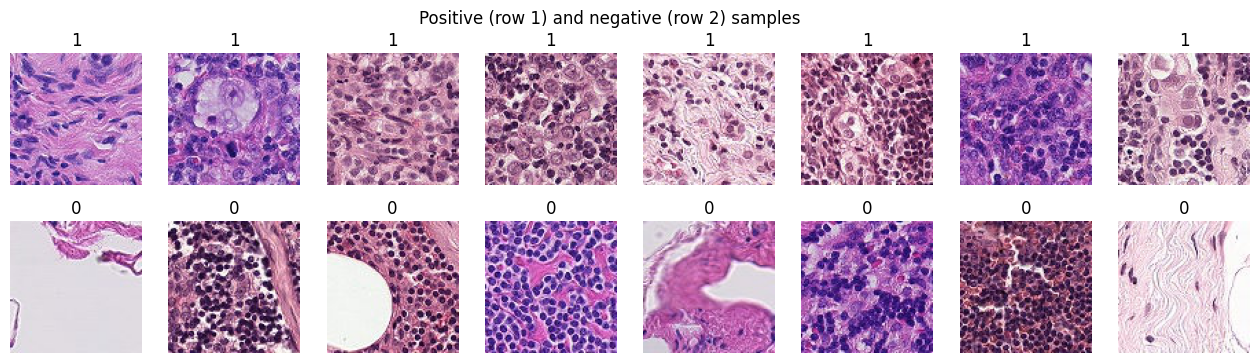

In [8]:
# Visualize random samples from each class
def load_image(img_id, directory):
    file_path = os.path.join(directory, f'{img_id}.tif')
    return Image.open(file_path)

positive_ids = labels_df[labels_df['label'] == 1]['id'].sample(8).tolist()
negative_ids = labels_df[labels_df['label'] == 0]['id'].sample(8).tolist()

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, img_id in enumerate(positive_ids):
    img = load_image(img_id, train_images_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('1')

for i, img_id in enumerate(negative_ids):
    img = load_image(img_id, train_images_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('0')

plt.suptitle('Positive (row 1) and negative (row 2) samples')
plt.show()

#### Visualize RGB Channels
- Plot the red, green, blue channels from a random training .tif file

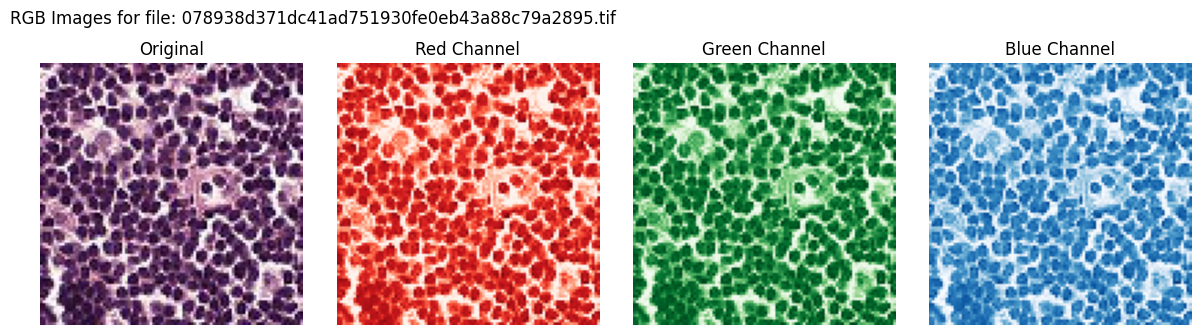

In [9]:
# Randomly select a training image
rand_idx = random.randint(0, len(os.listdir(train_images_path))+1)
filename = os.listdir(train_images_path)[rand_idx]

# Path to one example image
img_path = os.path.join(train_images_path, filename)

# Read the image (as NumPy array)
img = tiff.imread(img_path)

# Display each channel with its color
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ['Original', 'Red Channel', 'Green Channel', 'Blue Channel']
cmaps  = [None, 'Reds_r', 'Greens_r', 'Blues_r']

# Plot original RGB + individual color channels
axes[0].imshow(img)
axes[0].set_title(titles[0])
axes[0].axis('off')
for i, (title, cmap) in enumerate(zip(titles[1:], cmaps[1:])):
    axes[i+1].imshow(img[:, :, i], cmap=cmap)
    axes[i+1].set_title(title)
    axes[i+1].axis('off')
plt.tight_layout()
plt.suptitle(f'RGB Images for file: {filename}', y=1.1, horizontalalignment='right')
plt.show()

> Something about these RGB images...

#### RGB Histograms by Label
- Plot of distributions by label type 

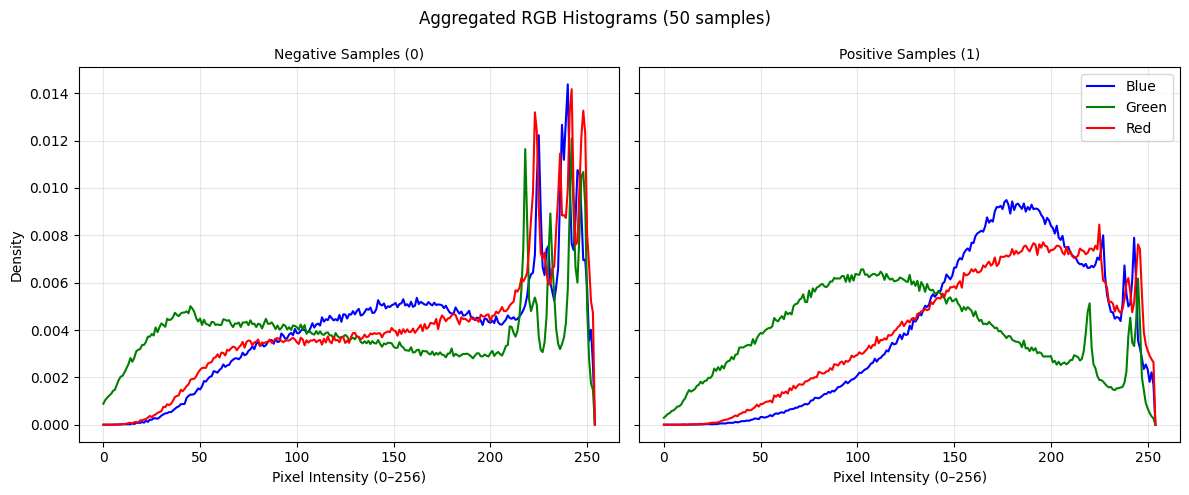

In [10]:
# Choose a random set of files from the positive (1) and negative (0) labels
n = 50
positive_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==1]['id'].sample(n).to_list()]
negative_files = [f'./train/{x}.tif' for x in labels_df[labels_df['label']==0]['id'].sample(n).to_list()]

# Function to create RGB histogram data
def get_histogram_data(files):
    hists = np.zeros((3, 255), dtype=np.float64)
    for path in files:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        for ch in range(3):
            hists[ch] += cv2.calcHist([img], [ch], None, [255], [1, 255]).ravel()
    return hists

# Get histogram data
negative_files_hist_data = get_histogram_data(negative_files)
positive_files_hist_data = get_histogram_data(positive_files)

negative_files_probability_data = negative_files_hist_data / negative_files_hist_data.sum(axis=1, keepdims=True)
positive_files_probability_data = positive_files_hist_data / positive_files_hist_data.sum(axis=1, keepdims=True)

# Plot RGB Histograms
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

ax0.plot(negative_files_probability_data[0], 'b', label='Blue')
ax0.plot(negative_files_probability_data[1], 'g', label='Green')
ax0.plot(negative_files_probability_data[2], 'r', label='Red')
ax0.set_title('Negative Samples (0)', fontdict={'fontsize':10})
ax0.set_xlabel('Pixel Intensity (0–256)')
ax0.set_ylabel('Density')
ax0.grid(True, alpha=0.3)

ax1.plot(positive_files_probability_data[0], 'b', label='Blue')
ax1.plot(positive_files_probability_data[1], 'g', label='Green')
ax1.plot(positive_files_probability_data[2], 'r', label='Red')
ax1.set_title('Positive Samples (1)', fontdict={'fontsize':10})
ax1.set_xlabel('Pixel Intensity (0–256)')
ax1.grid(True, alpha=0.3)
ax1.legend()

plt.suptitle(f'Aggregated RGB Histograms ({n:,} samples)')
plt.tight_layout()
plt.show()

> Visual differences between positive and negative samples...

#### Distribution of Labels
- Understand balance of dataset

Class counts:
label
0    130908
1     89117
Name: count, dtype: int64


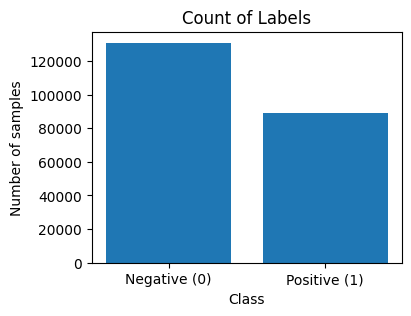

In [11]:
# Inspect label distribution
class_counts = labels_df['label'].value_counts().sort_index()
print('Class counts:')
print(class_counts)

# Plot label distribution
plt.figure(figsize=(4,3))
plt.bar(['Negative (0)', 'Positive (1)'], class_counts.values)
plt.title('Count of Labels')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

> Dataset is imbalanced....

#### Analysis Plan

Based on the EDA, the following observations guide our analysis:

- The label distribution shows a moderate class imbalance; using class weights or oversampling may help the model focus on minority (positive) samples.
- The images have strong staining variability and sometimes contain artefacts; data augmentation (random flips, rotations, brightness/contrast adjustments) can improve generalisation.

**Analysis plan:**

1. Split the labelled data into training and validation sets (e.g. 80/20).
2. Preprocess images: resize to a common size (96×96), apply augmentations on the fly, and normalise by global channel statistics.
3. Train several CNN architectures ranging from a simple custom CNN to transfer learning models (e.g. ResNet50, DenseNet169).
4. Tune hyperparameters such as learning rate, optimiser, dropout rate, batch size and number of layers using a search strategy (random search or Bayesian optimisation).
5. Evaluate the models on the validation set using metrics appropriate for class imbalance (AUC, precision, recall, F1).

## CNN Modeling

#### Train - Validation Split
- The Kaggle dataset only provides labels for the training images, so we will need to subdivide the training images into a training and validation set (80% training, 20% validation) in order to be able to test the performace of the CNN models.

In [12]:
# Split labels_df into training and validation sets 
training_ids, validation_ids, training_labels, validation_labels = train_test_split(
    labels_df['id'].values,
    labels_df['label'].values,
    test_size=0.2,
    random_state=666
)

# Create lists of training and validation filenames
training_filenames = [f'./train/{i}.tif' for i in training_ids]
validation_filenames = [f'./train/{i}.tif' for i in validation_ids]

In [13]:
def create_dataset(filenames, dataset_name):
    if not os.path.exists(f'{dataset_name}.npy'):
        print(f'Creating dataset: {dataset_name}')
        n = len(filenames)
        h = IMG_SIZE
        w = IMG_SIZE
        c = CHANNELS
        df = np.empty((n, h, w, c), dtype='uint8')
        for i, filename in enumerate(filenames):
            with Image.open(filename) as im:
                df[i] = np.array(im)
        
        # Save dataset
        print(f'Saving {dataset_name}.npy to directory\n')
        np.save(f'{dataset_name}.npy', df)
    else:
        print(f'The file {dataset_name}.npy already exists, loading the saved dataset from directory...\n')
        df = np.load(f'{dataset_name}.npy')

    return df

train_ds = create_dataset(training_filenames, 'train_ds')
val_ds = create_dataset(validation_filenames, 'val_ds')

The file train_ds.npy already exists, loading the saved dataset from directory...

The file val_ds.npy already exists, loading the saved dataset from directory...



In [ ]:
# # Create indicies along which to split data into training and validation sets 
# train_idx, val_idx = train_test_split(
#     np.arange(len(labels_df)),
#     test_size=0.20,
#     random_state=666,
#     stratify=train_labels_vec
# )

# # Create vectors of training and validation labels
# train_labels = train_labels_vec[train_idx]
# val_true_labels = train_labels_vec[val_idx]

# # Save split file lists for consistent TFRecord selection later
# split_meta = {
#     'train_ids': labels_df['id'].iloc[train_idx].tolist(),
#     'val_ids':   labels_df['id'].iloc[val_idx].tolist(),
# }
# with open('./tfrecords/split.json','w') as f: json.dump(split_meta, f)

# print(len(train_labels), len(val_true_labels))

#### Create Datasets

In [ ]:
# # Feature descriptions used to parse TFRecord Examples
# feature_desc_train = {
#     'image': tf.io.FixedLenFeature([], tf.string),
#     'height': tf.io.FixedLenFeature([], tf.int64),
#     'width':  tf.io.FixedLenFeature([], tf.int64),
#     'channels': tf.io.FixedLenFeature([], tf.int64),
#     'id': tf.io.FixedLenFeature([], tf.string),
#     'label': tf.io.FixedLenFeature([], tf.int64),
# }
# feature_desc_test = {k:v for k,v in feature_desc_train.items() if k!='label'}  # no label for test

# # Parser function to convert serialized Example into (image_tensor, label) tuples
# def parse_train(example):
#     ex = tf.io.parse_single_example(example, feature_desc_train)
#     img = tf.io.decode_jpeg(ex['image'], channels=3)
#     img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
#     img = tf.image.convert_image_dtype(img, tf.float32)  # 0..1 range
#     img = tf.ensure_shape(img, [IMG_SIZE, IMG_SIZE, CHANNELS])
#     label = tf.cast(ex['label'], tf.int32)
#     return img, label

# # Parser function to convert serialized Example into (image_tensor, id) tuples (for test)
# def parse_test(example):
#     ex = tf.io.parse_single_example(example, feature_desc_test)
#     img = tf.io.decode_jpeg(ex['image'], channels=3)
#     img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.ensure_shape(img, [IMG_SIZE, IMG_SIZE, CHANNELS])
#     return img, ex['id']

# # Parser helpers used for train/val filtering pipeline that include the id
# def parse_train_with_id(example):
#     ex = tf.io.parse_single_example(example, feature_desc_train)
#     img = tf.io.decode_jpeg(ex['image'], channels=3)
#     img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.ensure_shape(img, [IMG_SIZE, IMG_SIZE, CHANNELS])
#     label = tf.cast(ex['label'], tf.int32)
#     return img, label, ex['id']

# def strip_id(img, label, ex_id):
#     return img, label

# # Add helper to get tfrecord file list and id tensor (must run before using train_files_tfrec)
# def tfrecord_files_for(split_ids, directory='./tfrecords/train'):
#     return sorted(glob.glob(os.path.join(directory, '*.tfrec'))), tf.constant(split_ids)

# # Load saved split metadata and build dataset file lists (ensure this runs before building datasets)
# with open('./tfrecords/split.json') as f:
#     meta = json.load(f)

# train_files_tfrec, train_ids_tensor = tfrecord_files_for(meta['train_ids'])
# val_files_tfrec, val_ids_tensor = tfrecord_files_for(meta['val_ids'])

# train_ids_values = tf.ones(tf.shape(train_ids_tensor), dtype=tf.int32)
# val_ids_values = tf.ones(tf.shape(val_ids_tensor), dtype=tf.int32)

# train_ids_lookup = tf.lookup.StaticHashTable(
#     tf.lookup.KeyValueTensorInitializer(train_ids_tensor, train_ids_values), default_value=0)
# val_ids_lookup = tf.lookup.StaticHashTable(
#     tf.lookup.KeyValueTensorInitializer(val_ids_tensor, val_ids_values), default_value=0)

# # *** FIX: define the filter functions BEFORE using them in .filter(...) ***
# def filter_by_ids_train(img, label, ex_id):
#     # train_ids_lookup.lookup returns 1 for ids present, 0 otherwise
#     return train_ids_lookup.lookup(ex_id) > 0

# def filter_by_ids_val(img, label, ex_id):
#     return val_ids_lookup.lookup(ex_id) > 0

# # Build training dataset (repeat() kept so we drive epochs via steps_per_epoch)
# train_ds = (
#     tf.data.TFRecordDataset(train_files_tfrec, compression_type='GZIP', num_parallel_reads=AUTOTUNE)
#     .map(parse_train_with_id, num_parallel_calls=AUTOTUNE)
#     .filter(filter_by_ids_train)
#     .map(strip_id, num_parallel_calls=AUTOTUNE)
#     .shuffle(8192, seed=666, reshuffle_each_iteration=True)  # mixing
#     .repeat()
#     .batch(BATCH_SIZE)
#     .prefetch(AUTOTUNE)
# )

# # Build validation dataset (finite)
# val_ds = (
#     tf.data.TFRecordDataset(val_files_tfrec, compression_type='GZIP', num_parallel_reads=AUTOTUNE)
#     .map(parse_train_with_id, num_parallel_calls=AUTOTUNE)
#     .filter(filter_by_ids_val)
#     .map(strip_id, num_parallel_calls=AUTOTUNE)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTOTUNE)
# )

# # Build test dataset (finite)
# test_ds = (
#     tf.data.TFRecordDataset(sorted(glob.glob('./tfrecords/test/*.tfrec')), compression_type='GZIP', num_parallel_reads=AUTOTUNE)
#     .map(parse_test, num_parallel_calls=AUTOTUNE)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTOTUNE)
# )

#### Model Fitting & Evaluations Helper Functions

In [8]:
# Function used to fit a CNN model (or load from the directory if a fit model already exists)
def fit_CNN_model(model):
    checkpoint_path = f'{model.name}_best_model.weights.h5'
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='AUC', mode='max', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='AUC', mode='max', save_best_only=True, save_weights_only=True)
    ]

    # compute steps_per_epoch from the saved split metadata
    n_train = len(labels_df)
    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

    if not os.path.exists(checkpoint_path):
        # Fit and return the History object
        history = model.fit(
            x = train_ds,
            y = training_labels,
            batch_size = BATCH_SIZE,
            epochs=3,
            callbacks=callbacks,
            verbose=1,
        )
        return history
    else:
        model.load_weights(checkpoint_path)
        print(f'Loaded existing weights from {checkpoint_path}')
        return model

In [ ]:
# Function used to create evaluation outputs


#### Baseline CNN Model

In [9]:
# Function to create an instance of baseline CNN model
def make_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.10),
        tf.keras.layers.RandomZoom(0.10),
        tf.keras.layers.RandomContrast(0.10),
        tf.keras.layers.Rescaling(1./255),
    ], name='preprocess')

    x_in = tf.keras.layers.Input(shape=input_shape)
    x = aug(x_in)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(x_in, out, name='baseline_cnn_model')
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC','accuracy'])
    return model

# Create the baseline model instance
baseline_cnn_model = make_baseline_cnn()

# Display baseline model structure
baseline_cnn_model.summary()

I0000 00:00:1762147316.990840    7716 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1762147316.993991    7716 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "baseline_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the baseline model
fit_model = fit_CNN_model(baseline_cnn_model)

Epoch 1/3
1722/2751 ━━━━━━━━━━━━━━━━━━━━ 2:19 136ms/step - AUC: 0.7918 - accuracy: 0.7371 - loss: 0.5292

In [ ]:
val_probs = fit_model.predict(val_ds, verbose=1).ravel()

In [ ]:
val_pred_labels = (val_probs >= 0.5).astype(np.int32)
print(val_pred_labels.shape)

In [ ]:
print(len(val_true_labels), len(val_pred_labels))

In [ ]:
print('ROC AUC:', roc_auc_score(val_true_labels, val_probs))
print(classification_report(val_true_labels, val_pred_labels, digits=4))

cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Validation Confusion Matrix')
plt.tight_layout()
plt.show()

## Results & Analysis
- Discuss and interpret results

#### Kaggle Submission

In [ ]:
# Get best model
# best_model = 

# Predict labels for test images


# Convert prediction into Kaggle submission format
test_ids = []
test_probs = []
for batch_imgs, batch_ids in test_ds:
    p = baseline_cnn_model.predict(batch_imgs, verbose=0).ravel()
    test_probs.extend(p.tolist())
    test_ids.extend([i.decode() for i in batch_ids.numpy()])

sub = pd.DataFrame({'id': test_ids, 'label': test_probs})
sub = sub.sort_values('id').reset_index(drop=True)
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
# Image of Kaggle submission


## Conclusion
- Summarize project
- Learnings and takeaways
- What did and did not help improve the performance of your models
- What improvements could you try in the future